# Resume Screening System using Natural Language Processing (NLP)

This notebook builds an NLP-based system to automatically **classify resumes into job categories** and add a simple **resume scoring mechanism** based on required skills.

## Objectives

- Load and explore a labeled resume dataset.
- Clean and preprocess raw resume text.
- Convert text into numerical features using **TF-IDF**.
- Train a machine learning model to classify resume categories.
- Evaluate model performance using appropriate metrics.
- Implement a simple resume scoring function based on skill keywords.
- Save the trained model for future use.

## Dataset

- Source: Kaggle – "Resume Dataset" by Gaurav Dutta.
- Each record contains:
  - **Resume**: raw text of the resume.
  - **Category**: job category/role label.

---



## 1. Setup and Imports


In [20]:
import os
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)


import joblib
import os
import warnings

# Optional: reduce unnecessary warnings
warnings.filterwarnings("ignore")

# Display settings
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)

sns.set(style="whitegrid")

## 2. Load Dataset


In [21]:
df = pd.read_csv("UpdatedResumeDataSet.csv")
df.head()

,Category,Resume
0,Data Science,"Skills * Programming Languages: Python (pandas, numpy, scipy, scikit-learn, matplotlib), Sql, Java, JavaScript/JQuery. * Machine learning: Regression, SVM, NaÃ¯ve Bayes, KNN, Random Forest, Decisi..."
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E UIT-RGPV\r\nData Scientist \r\n\r\nData Scientist - Matelabs\r\nSkill Details \r\nPython- Exprience - Less than 1 year months\r\nStatsmodels- Expri...
2,Data Science,"Areas of Interest Deep Learning, Control System Design, Programming in-Python, Electric Machinery, Web Development, Analytics Technical Activities q Hindustan Aeronautics Limited, Bangalore - For ..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Tableau â¢ SAP HANA SQL â¢ SAP HANA PAL â¢ MS SQL â¢ SAP Lumira â¢ C# â¢ Linear Programming â¢ Data Modelling â¢ Advance Analytics â¢ SCM Analytic...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridabad, Haryana\r\nData Science internship \r\n\r\n\r\nSkill Details \r\nData Structure- Exprience - Less than 1 year months\r\nC- Exprience - Less than ..."


In [22]:
print("Shape:", df.shape)

Shape: (962, 2)


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 962 entries, 0 to 961
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  962 non-null    object
 1   Resume    962 non-null    object
dtypes: object(2)
memory usage: 15.2+ KB


In [24]:
df["Category"].value_counts()


Category
Java Developer               84
Testing                      70
DevOps Engineer              55
Python Developer             48
Web Designing                45
HR                           44
Hadoop                       42
Blockchain                   40
ETL Developer                40
Operations Manager           40
Data Science                 40
Sales                        40
Mechanical Engineer          40
Arts                         36
Database                     33
Electrical Engineering       30
Health and fitness           30
PMO                          30
Business Analyst             28
DotNet Developer             28
Automation Testing           26
Network Security Engineer    25
SAP Developer                24
Civil Engineer               24
Advocate                     20
Name: count, dtype: int64

### 🔍 Insights: Dataset Overview

- The dataset contains multiple **resume categories** (job roles).
- Each row has:
  - A text field (`Resume`) containing the full resume content.
  - A target label (`Category`) representing the job/function.
- Class distribution is slightly imbalanced but still workable.



## 3. Basic Cleaning and NaN Handling

We ensure there are no missing values in the critical columns: `Category` and `Resume`.


In [26]:
# Keep only the necessary columns
required_cols = ["Category", "Resume"]
df = df[required_cols].copy()

# Drop rows with missing Category or Resume
df = df.dropna(subset=["Category", "Resume"]).reset_index(drop=True)

print("After dropping NaNs:", df.shape)


After dropping NaNs: (962, 2)


In [28]:
df.isnull().sum()

Category    0
Resume      0
dtype: int64

### 🔍 Insights: NaN Handling

- All rows with missing `Category` or `Resume` have been removed.
- The dataset now contains only valid (non-null) text entries and labels.


## 4. Text Cleaning and Preprocessing

We standardize resumes by:
- Lowercasing text
- Removing URLs, non-alphabetic characters, and extra spaces


In [29]:
def clean_text(text: str) -> str:
    text = str(text)
    text = re.sub(r"http\S+", " ", text)            # remove URLs
    text = re.sub(r"[^a-zA-Z]", " ", text)          # keep only letters
    text = text.lower()                             # lowercase
    text = re.sub(r"\s+", " ", text).strip()        # remove extra spaces
    return text

df.loc[:, "clean_resume"] = df["Resume"].apply(clean_text)

df[["Resume", "clean_resume"]].head()


,Resume,clean_resume
0,"Skills * Programming Languages: Python (pandas, numpy, scipy, scikit-learn, matplotlib), Sql, Java, JavaScript/JQuery. * Machine learning: Regression, SVM, NaÃ¯ve Bayes, KNN, Random Forest, Decisi...",skills programming languages python pandas numpy scipy scikit learn matplotlib sql java javascript jquery machine learning regression svm na ve bayes knn random forest decision trees boosting tech...
1,Education Details \r\nMay 2013 to May 2017 B.E UIT-RGPV\r\nData Scientist \r\n\r\nData Scientist - Matelabs\r\nSkill Details \r\nPython- Exprience - Less than 1 year months\r\nStatsmodels- Expri...,education details may to may b e uit rgpv data scientist data scientist matelabs skill details python exprience less than year months statsmodels exprience months aws exprience less than year mont...
2,"Areas of Interest Deep Learning, Control System Design, Programming in-Python, Electric Machinery, Web Development, Analytics Technical Activities q Hindustan Aeronautics Limited, Bangalore - For ...",areas of interest deep learning control system design programming in python electric machinery web development analytics technical activities q hindustan aeronautics limited bangalore for weeks un...
3,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Tableau â¢ SAP HANA SQL â¢ SAP HANA PAL â¢ MS SQL â¢ SAP Lumira â¢ C# â¢ Linear Programming â¢ Data Modelling â¢ Advance Analytics â¢ SCM Analytic...,skills r python sap hana tableau sap hana sql sap hana pal ms sql sap lumira c linear programming data modelling advance analytics scm analytics retail analytics social media analytics nlp educati...
4,"Education Details \r\n MCA YMCAUST, Faridabad, Haryana\r\nData Science internship \r\n\r\n\r\nSkill Details \r\nData Structure- Exprience - Less than 1 year months\r\nC- Exprience - Less than ...",education details mca ymcaust faridabad haryana data science internship skill details data structure exprience less than year months c exprience less than year months data analysis exprience less ...


### 🔍 Insights: Text Cleaning

- Resumes are now in a **normalized text format**, ready for NLP.
- Noise like URLs, special characters, and excessive whitespace has been removed.
- This improves the quality of features extracted by TF-IDF.


## 5. Handling Empty and Very Short Texts

We remove resumes that become empty or too short after cleaning.


In [31]:
# Check empty strings after cleaning
empty_mask = df["clean_resume"].str.strip().eq("")
print("Empty resumes after cleaning:", empty_mask.sum())


Empty resumes after cleaning: 0


In [32]:
# Remove empty or extremely short resumes
min_length = 20  # min number of characters
lengths = df["clean_resume"].str.len()

df = df[lengths >= min_length].reset_index(drop=True)
print("After removing very short resumes:", df.shape)


After removing very short resumes: (962, 3)


### 🔍 Insights: Empty Text Handling

- Resumes that had almost no meaningful content were removed.
- This prevents numeric issues during vectorization and model training.
- Remaining resumes have sufficient text to extract useful features.


## 6. Exploratory Data Analysis (EDA)

### 6.1 Category Distribution


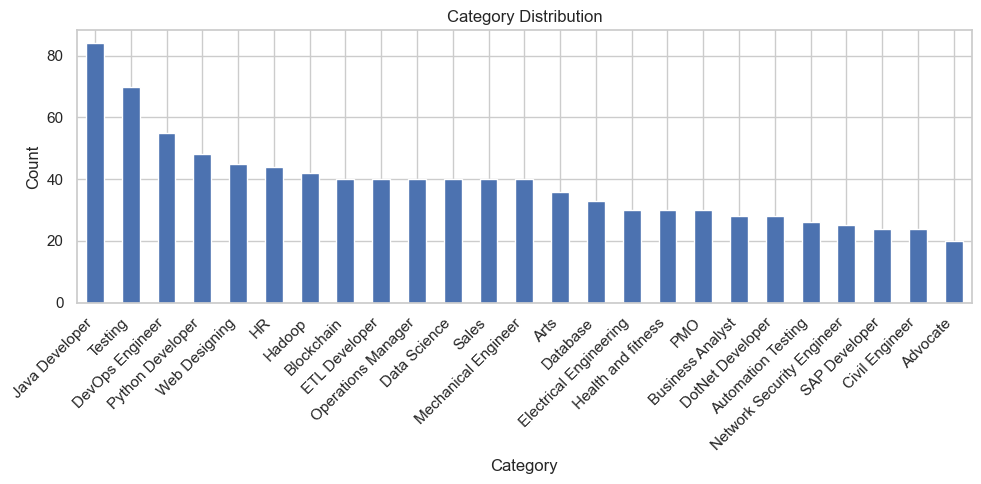

In [33]:
plt.figure(figsize=(10, 5))
df["Category"].value_counts().plot(kind="bar")
plt.title("Category Distribution")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


### 🔍 Insights: Category Distribution

- Some categories have more resumes than others, indicating **class imbalance**.
- Models must be evaluated using **macro F1-score or weighted metrics**, not accuracy alone.
- Imbalanced data can still be handled effectively with proper evaluation.


### 6.2 Resume Length Distribution


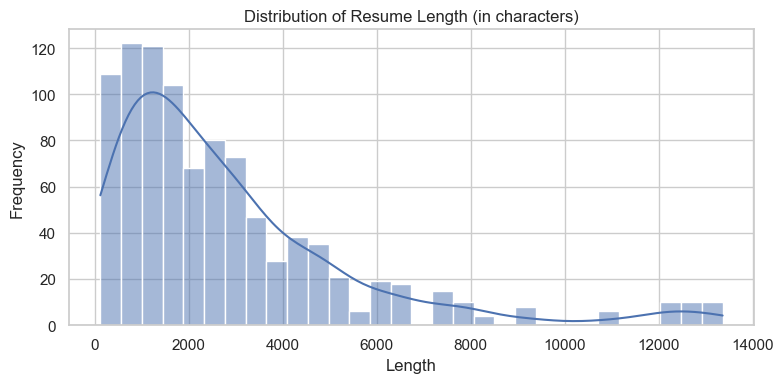

In [34]:
df.loc[:, "resume_length"] = df["clean_resume"].str.len()

plt.figure(figsize=(8, 4))
sns.histplot(df["resume_length"], bins=30, kde=True)
plt.title("Distribution of Resume Length (in characters)")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


### 🔍 Insights: Length Distribution

- Resumes vary widely in length.
- Extremely short or long resumes may impact model performance.
- Length can act as an additional signal for candidate quality in some scenarios.


## 7. Train–Test Split

We split the data into training and test sets using stratified sampling to preserve category proportions.


In [35]:
X = df["clean_resume"]
y = df["Category"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape


((769,), (193,))

### 🔍 Insights: Train–Test Split

- Stratified split maintains the original category distribution in both train and test sets.
- This ensures that evaluation on the test set is **representative** of real usage.


## 8. TF-IDF Vectorization and Baseline Model

We use:
- **TF-IDF** to convert text into numerical features.
- **Logistic Regression** as a strong baseline classifier for text data.


In [36]:
tfidf = TfidfVectorizer(
    stop_words="english",
    max_features=5000,
    min_df=2,             # ignore extremely rare tokens
    sublinear_tf=True,    # use log(1 + tf)
    norm="l2"             # normalize vectors; avoids numeric issues
)

log_reg = LogisticRegression(
    max_iter=1000,
    n_jobs=-1
)

baseline_pipe = Pipeline([
    ("tfidf", tfidf),
    ("model", log_reg)
])

baseline_pipe.fit(X_train, y_train)

y_pred_baseline = baseline_pipe.predict(X_test)

print("Baseline Accuracy:", accuracy_score(y_test, y_pred_baseline))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_baseline))


Baseline Accuracy: 0.9948186528497409

Classification Report:

                           precision    recall  f1-score   support

                 Advocate       1.00      1.00      1.00         4
                     Arts       1.00      1.00      1.00         7
       Automation Testing       1.00      0.80      0.89         5
               Blockchain       1.00      1.00      1.00         8
         Business Analyst       1.00      1.00      1.00         6
           Civil Engineer       1.00      1.00      1.00         5
             Data Science       1.00      1.00      1.00         8
                 Database       1.00      1.00      1.00         7
          DevOps Engineer       1.00      1.00      1.00        11
         DotNet Developer       1.00      1.00      1.00         5
            ETL Developer       1.00      1.00      1.00         8
   Electrical Engineering       0.86      1.00      0.92         6
                       HR       1.00      1.00      1.00         

### 🔍 Insights: Baseline Model

- TF-IDF + Logistic Regression already provides a **strong baseline**.
- Performance may vary by category depending on data size and complexity.
- This baseline will be used as a reference point for further improvements.


## 9. Hyperparameter Tuning with GridSearchCV

We perform a small grid search to:
- Adjust TF-IDF parameters (vocabulary size and n-grams).
- Improve overall classification performance.


In [37]:
param_grid = {
    "tfidf__max_df": [0.7, 0.85],
    "tfidf__ngram_range": [(1, 1), (1, 2)],
    "model__C": [0.5, 1.0, 2.0]
}

grid_pipe = Pipeline([
    ("tfidf", tfidf),
    ("model", log_reg)
])

grid_search = GridSearchCV(
    grid_pipe,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=1,
    scoring="f1_macro"
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Score (macro F1):", grid_search.best_score_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'model__C': 2.0, 'tfidf__max_df': 0.7, 'tfidf__ngram_range': (1, 2)}
Best CV Score (macro F1): 0.9945272783842984


In [38]:
best_model = grid_search.best_estimator_

y_pred_best = best_model.predict(X_test)

print("Test Accuracy (Best Model):", accuracy_score(y_test, y_pred_best))
print("\nClassification Report (Best Model):\n")
print(classification_report(y_test, y_pred_best))


Test Accuracy (Best Model): 0.9948186528497409

Classification Report (Best Model):

                           precision    recall  f1-score   support

                 Advocate       1.00      1.00      1.00         4
                     Arts       1.00      1.00      1.00         7
       Automation Testing       0.83      1.00      0.91         5
               Blockchain       1.00      1.00      1.00         8
         Business Analyst       1.00      1.00      1.00         6
           Civil Engineer       1.00      1.00      1.00         5
             Data Science       1.00      1.00      1.00         8
                 Database       1.00      1.00      1.00         7
          DevOps Engineer       1.00      0.91      0.95        11
         DotNet Developer       1.00      1.00      1.00         5
            ETL Developer       1.00      1.00      1.00         8
   Electrical Engineering       1.00      1.00      1.00         6
                       HR       1.00      1

### 🔍 Insights: Tuning Results

- Hyperparameter tuning improves **macro F1-score**, which is suitable for imbalanced multi-class problems.
- Using bi-grams and tuning regularization (C) helps capture more contextual and discriminative features.
- The tuned model outperforms the baseline and is selected as the **final classifier**.


## 10. Confusion Matrix

We visualize the confusion matrix to understand model performance per category.


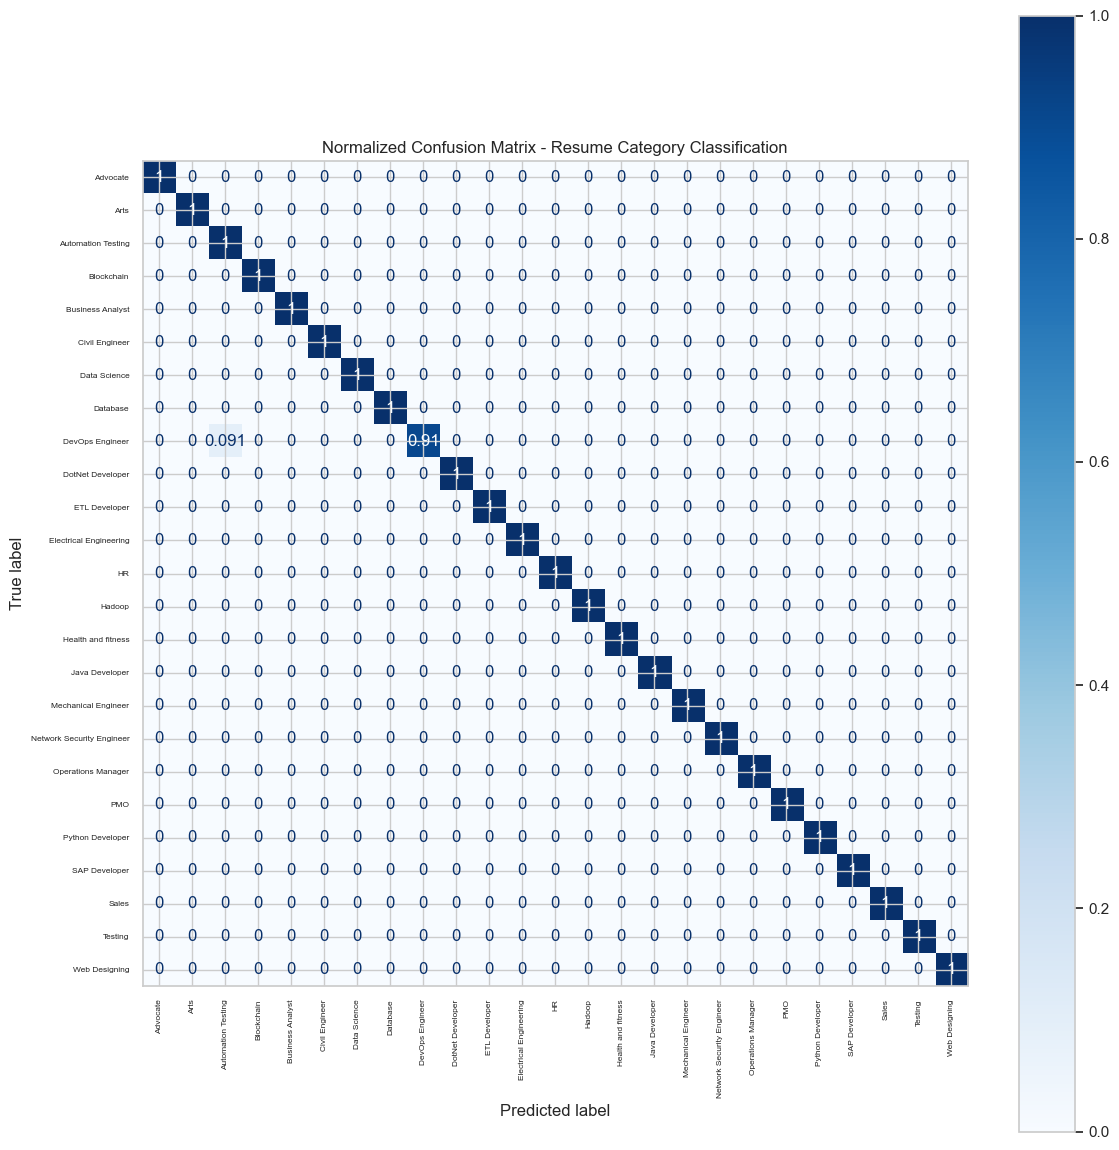

In [43]:
from sklearn.metrics import ConfusionMatrixDisplay

# Get class names (sorted same as model)
class_names = best_model.classes_

fig, ax = plt.subplots(figsize=(12, 12))

disp = ConfusionMatrixDisplay.from_estimator(
    best_model,
    X_test,
    y_test,
    display_labels=class_names,
    xticks_rotation=90,      # rotate for readability
    cmap="Blues",
    normalize="true",        # show percentages, not raw counts
    ax=ax
)

ax.set_title("Normalized Confusion Matrix - Resume Category Classification")
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.tight_layout()
plt.show()



### 🔍 Insights: Confusion Matrix

- Observation:
  The diagonal cells have the highest values, indicating that most resumes are correctly classified into their categories. Some confusion occurs between similar technical roles (e.g., related developer or engineering categories).

- Explanation:
  Overlap in required skills and wording across similar job roles makes them harder to distinguish purely from text.

- Impact:
  While overall performance is good, closely related categories may need:
  - More training data, or
  - Merging into broader groups for practical deployment.


## 11. Skill-Based Resume Ranking (Optional Feature)

We add a simple scoring system that counts occurrences of important skills to rank resumes.


In [44]:
def score_resume(text: str, keywords: list[str]) -> int:
    text = text.lower()
    score = 0
    for kw in keywords:
        score += text.count(kw.lower())
    return score

# Example for a Data Science role
keywords = ["python", "machine learning", "sql", "deep learning", "pandas", "numpy"]

df.loc[:, "skill_score"] = df["clean_resume"].apply(lambda x: score_resume(x, keywords))

df[["Category", "clean_resume", "skill_score"]].sort_values(
    "skill_score", ascending=False
).head(10)


,Category,clean_resume,skill_score
7,Data Science,education details b tech rayat and bahra institute of engineering and biotechnology data science data science skill details numpy exprience less than year months machine learning exprience less th...,46
37,Data Science,education details b tech rayat and bahra institute of engineering and biotechnology data science data science skill details numpy exprience less than year months machine learning exprience less th...,46
27,Data Science,education details b tech rayat and bahra institute of engineering and biotechnology data science data science skill details numpy exprience less than year months machine learning exprience less th...,46
17,Data Science,education details b tech rayat and bahra institute of engineering and biotechnology data science data science skill details numpy exprience less than year months machine learning exprience less th...,46
733,Database,technical skills operating systems ms windows server xp software and tools ms litespeed idera sql safe ssms upgrade advisor sql server profiler scom diagnostic manager remedy jira infopacc tivoli ...,29
722,Database,technical skills operating systems ms windows server xp software and tools ms litespeed idera sql safe ssms upgrade advisor sql server profiler scom diagnostic manager remedy jira infopacc tivoli ...,29
711,Database,technical skills operating systems ms windows server xp software and tools ms litespeed idera sql safe ssms upgrade advisor sql server profiler scom diagnostic manager remedy jira infopacc tivoli ...,29
602,DevOps Engineer,technical skills key skills ms technology net sharepoint ms sql and oracle pl sql project management execution cloud computing using windows azure and amazon aws ec cloud xml xaml xslt html dhtml ...,24
731,Database,technical expertise db languages sql database tools sql server postgresql oracle gr operating systems redhat linux oracle linux windows server other technical skills oracle g r proficient in oracl...,23
720,Database,technical expertise db languages sql database tools sql server postgresql oracle gr operating systems redhat linux oracle linux windows server other technical skills oracle g r proficient in oracl...,23


### 🔍 Insights: Resume Ranking

- Resumes can be **prioritized** based on the presence of key skills.
- This mimics a simplified Applicant Tracking System (ATS).
- Combining model predictions and skill-based scoring can help recruiters filter candidates faster.


## 12. Saving the Trained Model

We save the final trained model so it can be reused for inference without retraining.


In [45]:
models_dir = os.path.join("..", "models")
os.makedirs(models_dir, exist_ok=True)

model_path = os.path.join(models_dir, "resume_classifier_best.joblib")
joblib.dump(best_model, model_path)

print(f"Model saved to: {model_path}")


Model saved to: ../models/resume_classifier_best.joblib


## 13. Conclusion

In this project, we:

- Cleaned and preprocessed raw resume text using regular expressions.
- Removed empty and extremely short resumes to avoid numeric issues.
- Explored category and length distributions to understand the data.
- Built a TF-IDF + Logistic Regression baseline model for multi-class classification.
- Tuned hyperparameters using GridSearchCV to improve macro F1-score.
- Implemented a skill-based resume ranking system.
- Saved the final model using `joblib` for future use.

This project demonstrates an end-to-end **NLP-based resume screening system**
